## Import data

In [14]:
import pandas as pd
df1 = pd.read_parquet("validated_data/cleaned1.parquet")
df2 = pd.read_parquet("validated_data/cleaned2.parquet")
df3 = pd.read_parquet("validated_data/cleaned3.parquet")

dfs = [df1, df2, df3]
for i, df in enumerate(dfs):
    dfs[i] = df[df["Faulty"] == False]
    print(f"Building {i+1} has {len(dfs[i])} out of {len(df)} valid rows.")
df1, df2, df3 = dfs

Building 1 has 1058508 out of 2097150 valid rows.
Building 2 has 137790 out of 520938 valid rows.
Building 3 has 619925 out of 1942515 valid rows.


## Data preparation

Only keep columns with useful information.
- `Slab_temp` and `Dew_temp` values do not vary in building 1
- `building_no` is the same value within dataframes
- `Fan_on_group` and `Cumulative_fan_on_mins` values were calculated using the target variable `Fan_status`
- `Date` and `Time` cannot be easily converted to numeric values
- `Year` values should probably not be used for prediction
- `Damper_open_group` and `Louver_open_group` are categorical labels

In [15]:
exclude = ["building_no", "Fan_on_group", "Date", "Time", "Year", "Damper_open_group", "Louver_open_group", "Faulty", "Cumulative_fan_on_mins", "Cumulative_damper_open_mins", "Cumulative_louver_open_mins"]
exclude_df1 = exclude + ["Slab_temp", "Dew_temp", "Slab_temp_diff", "Dew_temp_diff"]

df1 = df1[df1.columns.difference(exclude_df1)]
df2 = df2[df2.columns.difference(exclude)]
df3 = df3[df3.columns.difference(exclude)]
dfs = [df1, df2, df3]

Use `Datetime` to get day of year and minutes past midnight

In [16]:
for df in dfs:
    df["Day_of_Year"] = df["Datetime"].dt.day_of_year
    df["Minutes_past_midnight"] = ((df["Datetime"] - df["Datetime"].dt.normalize()) / pd.Timedelta(minutes=1))
    df["DOW"] = df["Datetime"].dt.day_name().astype("category")
    del df["Datetime"]

<Axes: >

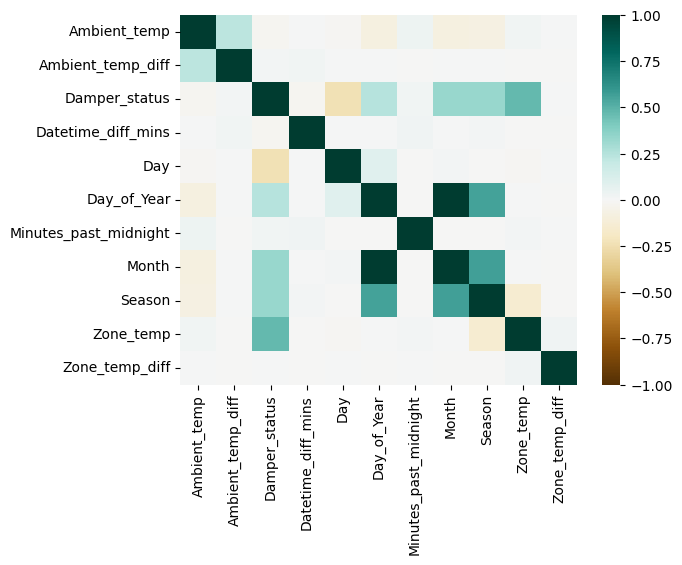

In [17]:
import seaborn as sns
sns.heatmap(df1[df1.columns.difference(["Fan_status", "Zone_name", "DOW"])].corr(), cmap="BrBG", vmin=-1, vmax=1)

In [18]:
print(len(df1))
df1.isna().sum()

1058508


Ambient_temp              11022
Ambient_temp_diff         21648
DOW                           0
Damper_status            955182
Datetime_diff_mins            0
Day                           0
Fan_status                    0
Month                         0
Season                        0
Zone_name                     0
Zone_temp                     0
Zone_temp_diff                0
Day_of_Year                   0
Minutes_past_midnight         0
dtype: int64

In [19]:
print(len(df2))
df2.isna().sum()

137790


Ambient_temp               4790
Ambient_temp_diff          4795
DOW                           0
Datetime_diff_mins            0
Day                           0
Dew_temp                      0
Dew_temp_diff                 0
Fan_status                    0
Month                         0
Season                        0
Slab_temp                     0
Slab_temp_diff                0
Zone_c02                  14195
Zone_name                     0
Zone_temp                110232
Zone_temp_diff           110232
Day_of_Year                   0
Minutes_past_midnight         0
dtype: int64

In [20]:
print(len(df3))
df3.isna().sum()

619925


Ambient_temp                  0
Ambient_temp_diff            45
DOW                           0
Damper_status                 0
Datetime_diff_mins           15
Day                           0
Dew_temp                   4389
Dew_temp_diff              4453
Fan_status                    0
Louver_status            619925
Month                         0
Season                        0
Slab_temp                   812
Slab_temp_diff              868
Zone_c02                     22
Zone_name                     0
Zone_temp                  2670
Zone_temp_diff             2730
Day_of_Year                   0
Minutes_past_midnight         0
dtype: int64

Encode `Zone_name` as numeric variables.

In [21]:
categorical_columns = ["Zone_name", "DOW"]
df1 = pd.get_dummies(df1, columns=categorical_columns)
dfs[0] = df1
df2 = pd.get_dummies(df2, columns=categorical_columns)
dfs[1] = df2
df3 = pd.get_dummies(df3, columns=categorical_columns)
dfs[2] = df3

## Split datasets into training and testing subsets
We use a 80% training, 10% validation, 10% testing split.

In [22]:
from sklearn.model_selection import train_test_split

train1, test1 = train_test_split(df1, test_size=0.2, random_state=42)
val1, test1 = train_test_split(test1, test_size=0.5, random_state=42)
train2, test2 = train_test_split(df2, test_size=0.2, random_state=42)
val2, test2 = train_test_split(test2, test_size=0.5, random_state=42)
train3, test3 = train_test_split(df3, test_size=0.2, random_state=42)
val3, test3 = train_test_split(test3, test_size=0.5, random_state=42)

Use random undersampling to handle unbalanced training sets.

In [23]:
target = "Fan_status"

for train in [train1, train2, train3]:
    counts = train[target].value_counts()
    if counts["On"] > counts["Off"] * 3:
        # data is already in random order, so we can just remove the relevant records after the cutoff
        drop = train[train[target] == "On"].index[counts["Off"] * 3:]
        train.drop(drop, inplace=True)
    elif counts["Off"] > counts["On"] * 3:
        drop = train[train[target] == "Off"].index[counts["On"] * 3:]
        train.drop(drop, inplace=True)

In [24]:
features1 = df1.columns.to_list()
features1.remove(target)
y_train1 = train1[target]
y_val1 = val1[target]
y_test1 = test1[target]
x_train1 = train1[features1]
x_val1 = val1[features1]
x_test1 = test1[features1]

features2 = df2.columns.to_list()
features2.remove(target)
y_train2 = train2[target]
y_val2 = val2[target]
y_test2 = test2[target]
x_train2 = train2[features2]
x_val2 = val2[features2]
x_test2 = test2[features2]

features3 = df3.columns.to_list()
features3.remove(target)
y_train3 = train3[target]
y_val3 = val3[target]
y_test3 = test3[target]
x_train3 = train3[features3]
x_val3 = val3[features3]
x_test3 = test3[features3]

## Evaluating Model Performance

In [25]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, matthews_corrcoef
from sklearn.pipeline import Pipeline

def calculate_metrics(model: Pipeline, X: pd.Series, y: pd.Series, print_report = True):
    y_predict = model.predict(X)
    y_proba = model.predict_proba(X)[:,1]

    if print_report:
        print(classification_report(y, y_predict, digits=4))

    return {
        "Accuracy": accuracy_score(y, y_predict),
        "ROC AUC": roc_auc_score(y, y_proba),
        "Matthews": matthews_corrcoef(y, y_predict)
    }

model_metrics = {f"Building {n+1}": {} for n in range(3)}

## Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

tree = DecisionTreeClassifier(random_state=42)
model_name = "Decision Tree"

### Building 1

[Text(0.5, 0.8333333333333334, 'Zone_temp <= 15.55\ngini = 0.388\nsamples = 846806\nvalue = [223280.0, 623526.0]'),
 Text(0.25, 0.5, 'Zone_temp <= 2.75\ngini = 0.027\nsamples = 110494\nvalue = [108984, 1510]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'Day_of_Year <= 7.5\ngini = 0.262\nsamples = 736312\nvalue = [114296, 622016]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

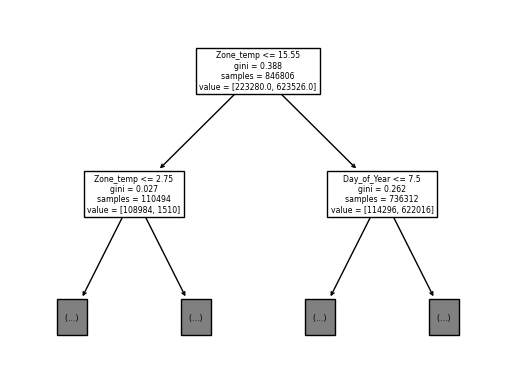

In [27]:
tree.fit(x_train1, y_train1)
plot_tree(tree, max_depth=1, feature_names=features1)

In [28]:
model_metrics["Building 1"][model_name] = calculate_metrics(tree, x_val1, y_val1)

              precision    recall  f1-score   support

         Off     0.9997    0.9994    0.9995     27625
          On     0.9998    0.9999    0.9998     78226

    accuracy                         0.9998    105851
   macro avg     0.9997    0.9997    0.9997    105851
weighted avg     0.9998    0.9998    0.9998    105851



### Building 2

[Text(0.5, 0.8333333333333334, 'Slab_temp_diff <= 0.005\ngini = 0.375\nsamples = 57464\nvalue = [43098, 14366]'),
 Text(0.25, 0.5, 'Zone_c02 <= 491.425\ngini = 0.275\nsamples = 36168\nvalue = [30227, 5941]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'Zone_name_Ac-2-2 <= 0.5\ngini = 0.478\nsamples = 21296\nvalue = [12871, 8425]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

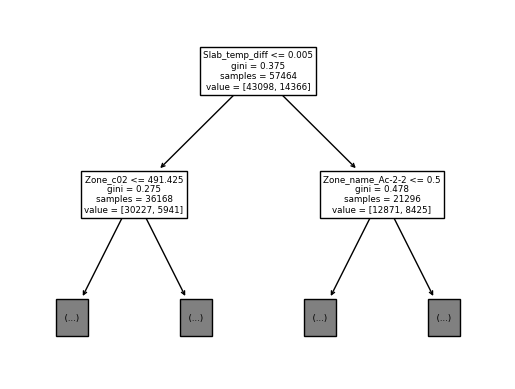

In [29]:
tree.fit(x_train2, y_train2)
plot_tree(tree, max_depth=1, feature_names=features2)

In [30]:
model_metrics["Building 2"][model_name] = calculate_metrics(tree, x_val2, y_val2)

              precision    recall  f1-score   support

         Off     0.9819    0.9615    0.9716     11990
          On     0.7734    0.8815    0.8239      1789

    accuracy                         0.9511     13779
   macro avg     0.8777    0.9215    0.8978     13779
weighted avg     0.9549    0.9511    0.9524     13779



### Building 3

[Text(0.625, 0.875, 'Zone_name_L1-03 <= 0.5\ngini = 0.375\nsamples = 486824\nvalue = [365118, 121706]'),
 Text(0.5, 0.625, 'Damper_status <= 34.167\ngini = 0.315\nsamples = 453925\nvalue = [365118, 88807]'),
 Text(0.25, 0.375, 'Day_of_Year <= 356.5\ngini = 0.141\nsamples = 309756\nvalue = [286084, 23672]'),
 Text(0.125, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.375, 'Damper_status <= 59.8\ngini = 0.495\nsamples = 144169\nvalue = [79034, 65135]'),
 Text(0.625, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'gini = 0.0\nsamples = 32899\nvalue = [0, 32899]')]

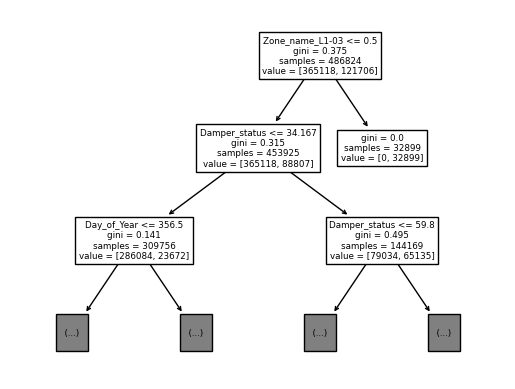

In [31]:
tree.fit(x_train3, y_train3)
plot_tree(tree, max_depth=2, feature_names=features3)

In [32]:
model_metrics["Building 3"][model_name] = calculate_metrics(tree, x_val3, y_val3)

              precision    recall  f1-score   support

         Off     0.9917    0.9922    0.9920     46578
          On     0.9764    0.9750    0.9757     15414

    accuracy                         0.9879     61992
   macro avg     0.9840    0.9836    0.9838     61992
weighted avg     0.9879    0.9879    0.9879     61992



## Random Forest
### Building 1

<Axes: >

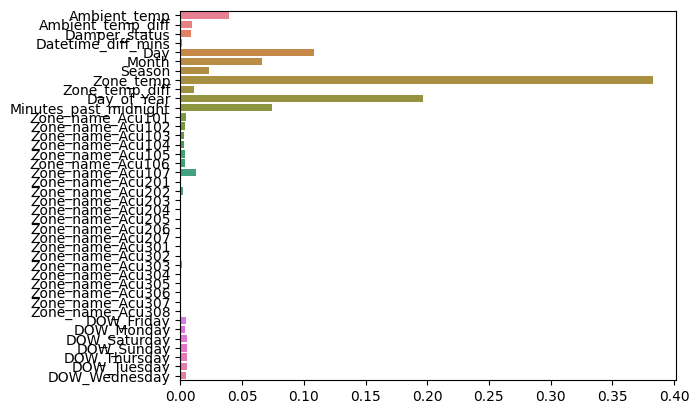

In [34]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

forest = RandomForestClassifier(random_state=42, n_jobs=-1)
forest.fit(x_train1, y_train1)
sns.barplot(pd.DataFrame(forest.feature_importances_, index=features1).T, orient="h")

In [35]:
model_name = "Random Forest"
model_metrics["Building 1"][model_name] = calculate_metrics(forest, x_val1, y_val1)

              precision    recall  f1-score   support

         Off     0.9994    0.9991    0.9992     27625
          On     0.9997    0.9998    0.9997     78226

    accuracy                         0.9996    105851
   macro avg     0.9995    0.9994    0.9995    105851
weighted avg     0.9996    0.9996    0.9996    105851



### Building 2

<Axes: >

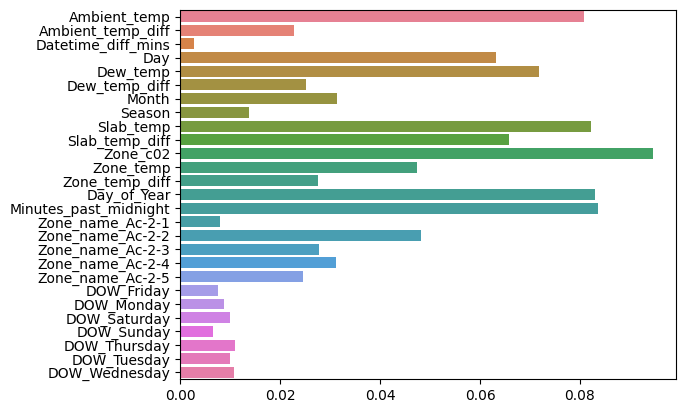

In [36]:
forest = RandomForestClassifier(random_state=42, n_jobs=-1)
forest.fit(x_train2, y_train2)
sns.barplot(pd.DataFrame(forest.feature_importances_, index=features2).T, orient="h")

In [37]:
model_metrics["Building 2"][model_name] = calculate_metrics(forest, x_val2, y_val2)

              precision    recall  f1-score   support

         Off     0.9869    0.9818    0.9844     11990
          On     0.8822    0.9128    0.8973      1789

    accuracy                         0.9729     13779
   macro avg     0.9346    0.9473    0.9408     13779
weighted avg     0.9733    0.9729    0.9731     13779



### Building 3

<Axes: >

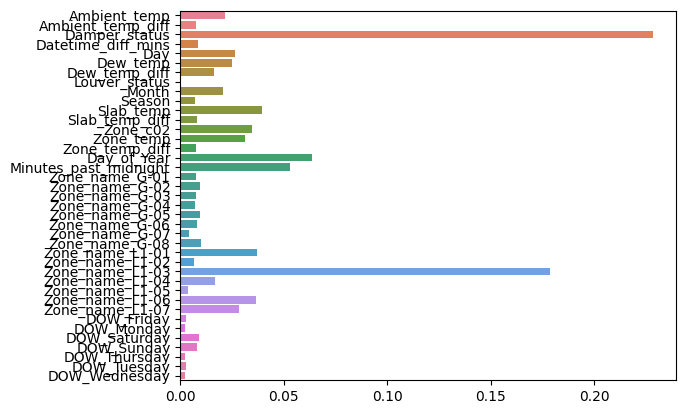

In [38]:
forest = RandomForestClassifier(random_state=42, n_jobs=-1)
forest.fit(x_train3, y_train3)
sns.barplot(pd.DataFrame(forest.feature_importances_, index=features3).T, orient="h")

In [39]:
model_metrics["Building 3"][model_name] = calculate_metrics(forest, x_val3, y_val3)

              precision    recall  f1-score   support

         Off     0.9922    0.9967    0.9945     46578
          On     0.9899    0.9764    0.9831     15414

    accuracy                         0.9917     61992
   macro avg     0.9911    0.9866    0.9888     61992
weighted avg     0.9917    0.9917    0.9916     61992



## 

## Model Performance
### Building 1

In [40]:
pd.DataFrame(model_metrics["Building 1"]).T

,Accuracy,ROC AUC,Matthews
Decision Tree,0.999764,0.999653,0.999388
Random Forest,0.999603,0.999999,0.998971


### Building 2

In [41]:
pd.DataFrame(model_metrics["Building 2"]).T

,Accuracy,ROC AUC,Matthews
Decision Tree,0.951085,0.921483,0.797962
Random Forest,0.972857,0.991812,0.881791


### Building 3

In [42]:
pd.DataFrame(model_metrics["Building 3"]).T

,Accuracy,ROC AUC,Matthews
Decision Tree,0.987902,0.983571,0.967605
Random Forest,0.991660,0.999492,0.977618


## Model Tuning

### Decision Tree

[Text(0.5, 0.8333333333333334, 'Slab_temp_diff <= 0.005\ngini = 0.375\nsamples = 57464\nvalue = [43098, 14366]'),
 Text(0.25, 0.5, 'Zone_c02 <= 491.425\ngini = 0.275\nsamples = 36168\nvalue = [30227, 5941]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'Zone_name_Ac-2-2 <= 0.5\ngini = 0.478\nsamples = 21296\nvalue = [12871, 8425]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

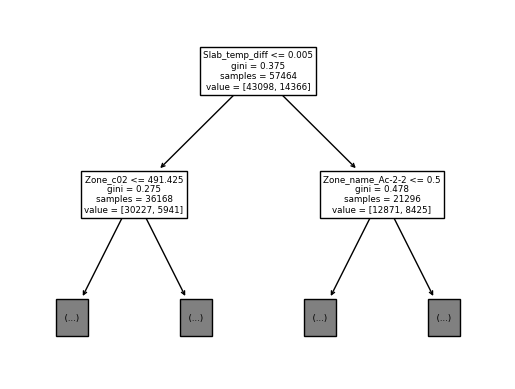

In [62]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(x_train2, y_train2)
path = tree.cost_complexity_pruning_path(x_train2, y_train2)
ccp_alphas = path.ccp_alphas
plot_tree(tree, max_depth=1, feature_names=features2)

Creating and evaluating all model variants takes a long time to complete from scratch. Data will be cached so that future runs will not take as long.

In [120]:
from pathlib import Path

model_name = "decision_tree"
building_name = "building2"
output_folder = Path(f"output/{model_name}/{building_name}")
Path(output_folder).mkdir(parents=True, exist_ok=True)

In [121]:
columns = ["alpha", "depth", "nodes"]
trees = {c: [] for c in columns}

# read cached data from file if it exists
index_file = output_folder / "trees.pkl"
if index_file.is_file():
    temp = pd.read_pickle(index_file)
    if not all(c in trees for c in columns):
        # column names are different
        temp = trees
    if not all(a in ccp_alphas for a in temp["alpha"]):
        # alpha values are different
        temp = trees
    trees = temp

In [122]:
from tqdm import tqdm

alphas_to_check = []
for ccp_alpha in ccp_alphas:
    if ccp_alpha not in trees["alpha"] and ccp_alpha not in alphas_to_check:
        alphas_to_check.append(ccp_alpha)

for ccp_alpha in tqdm(alphas_to_check):
    if ccp_alpha in trees["alpha"]:
        continue
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(x_train2, y_train2)

    predictions = pd.DataFrame({
        "predict": clf.predict(x_train2),
        "proba": clf.predict_proba(x_train2)[:,1]
    }, index=train2.index)

    n = str(len(trees["alpha"]))
    predictions.to_pickle(output_folder / f"{n}.pkl")

    trees["alpha"].append(ccp_alpha)
    trees["depth"].append(clf.tree_.max_depth)
    trees["nodes"].append(clf.tree_.node_count)

    pd.to_pickle(trees, index_file)

100%|██████████| 1234/1234 [12:20<00:00,  1.67it/s]


In [39]:
results = {}
for ccp_alpha, clf in zip(ccp_alphas, trees):
    results[ccp_alpha] = {
        "train": calculate_metrics(clf, x_train2, y_train2, False),
        "val": calculate_metrics(clf, x_val2, y_val2, False),
    }
    print(".", end="")

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

<Axes: xlabel='ccp_alpha', ylabel='value'>

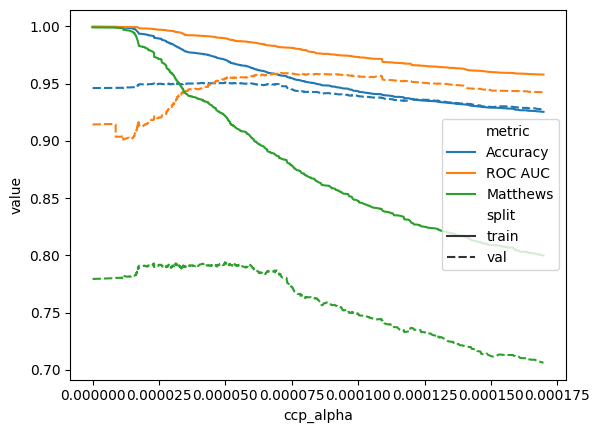

In [70]:
df = []
for ccp_alpha, result in results.items():
    for split, metrics in result.items():
        for metric, value in metrics.items():
            df.append({
                "ccp_alpha": ccp_alpha,
                "split": split,
                "metric": metric,
                "value": value
            })
df = pd.DataFrame(df)
df.to_csv("building2_decisiontree.csv")
sns.lineplot(df[:6*1000], x="ccp_alpha", y="value", hue="metric", style="split")